In [5]:
import math

from IPython import display

from matplotlib import cm, gridspec
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
from tensorflow.python.data import Dataset

from sklearn import metrics

import numpy as np
import pandas as pd

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:1f}'.format

In [14]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [8]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [15]:
california_housing_dataframe['median_house_value'] /= 1000

In [16]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66.900000
1,-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80.100000
2,-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85.700000
3,-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73.400000
4,-114.570000,33.570000,20.000000,1454.000000,326.000000,624.000000,262.000000,1.925000,65.500000


In [25]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Creates batches for ML algorithm
    Args:
        features: pandas DataFrame of features
        targets: pd dataFrame of targets
        batch_size: number of examples to be passed to the model
        shuffle: 
        num_epochs: number for which to repeat the batches
    Returns: 
        tuple (features, labels) for next data batch
    """
#     print('my_input_fn called')
    features = {key: np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, targets = ds.make_one_shot_iterator().get_next()
    return features, targets

In [36]:
def train_model(learning_rate, steps, batch_size, input_feature):
    """
    Creates linear model for california housing data frame
    Args:
    Returns: 
        pd.DataFrame - prediction results summary
    """

    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')

    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size, True, num_epochs=None)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size, False, num_epochs=1)

    feature_columns = [tf.feature_column.numeric_column(my_feature)]

    my_opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt, 5.0)
    linReg = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_opt)



    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]  
    
     # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linReg.train(input_fn = training_input_fn, steps=steps_per_period)
        
        predictions = linReg.predict(input_fn = predict_training_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
            # Compute loss.
        root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])

        weight = linReg.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linReg.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                                           sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(2, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    

    # Create a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    plt.subplot(2, 2, 3)
    plt.xlabel('targets')
    plt.ylabel('predictions')
    plt.scatter(calibration_data['targets'], calibration_data['predictions'])

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

    return calibration_data
    

In [27]:
# california_housing_dataframe = pd.DataFrame({'x': np.arange(10, 20, 1), 'median_house_value': 2*np.arange(10, 20, 1) + np.random.random(10)})

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.29
  period 05 : 179.23
  period 06 : 173.57
  period 07 : 169.46
  period 08 : 167.02
  period 09 : 166.32
Model training finished.


,predictions,targets
count,17000.000000,17000.000000
mean,132.183365,207.299591
std,108.997246,115.984344
min,0.100029,14.999000
25%,73.100021,119.400002
50%,106.350014,180.399994
75%,157.562504,265.000000
max,1896.849731,500.001007


Final RMSE (on training data): 166.32


,predictions,targets
0,280.600006,66.900002
1,382.499969,80.099998
2,36.000023,85.699997
3,75.050018,73.400002
4,72.700020,65.500000
...,...,...
16995,110.850014,111.400002
16996,117.450012,79.000000
16997,133.850006,103.599998
16998,133.600006,85.800003


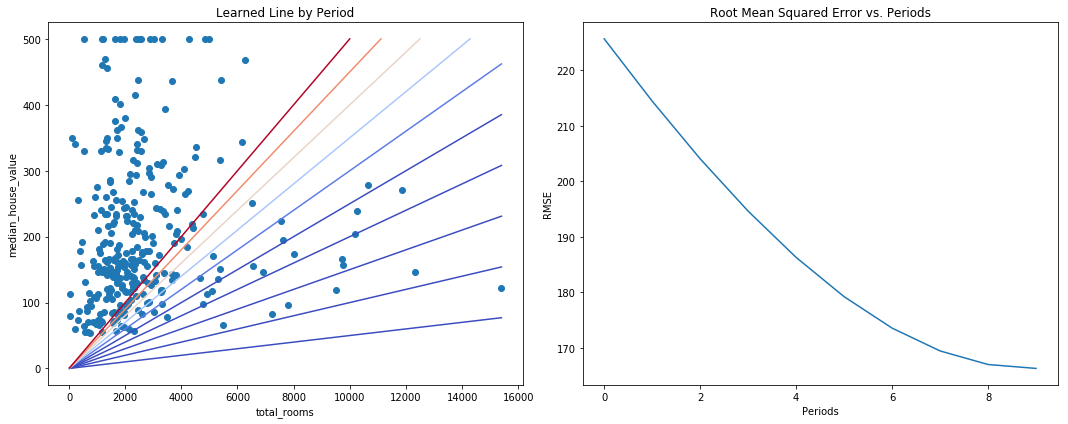

In [28]:
train_model(.001, steps=500, batch_size=5, input_feature='total_rooms')

In [29]:
california_housing_dataframe['rooms_per_person'] = california_housing_dataframe['total_rooms']/california_housing_dataframe['population']

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 190.30
  period 02 : 171.11
  period 03 : 155.24
  period 04 : 144.20
  period 05 : 137.54
  period 06 : 134.23
  period 07 : 132.71
  period 08 : 130.99
  period 09 : 130.71
Model training finished.


,predictions,targets
count,17000.000000,17000.000000
mean,183.499664,207.299591
std,84.356407,115.984344
min,41.877186,14.999000
25%,150.384167,119.400002
50%,180.635681,180.399994
75%,206.360619,265.000000
max,4024.869385,500.001007


Final RMSE (on training data): 130.71


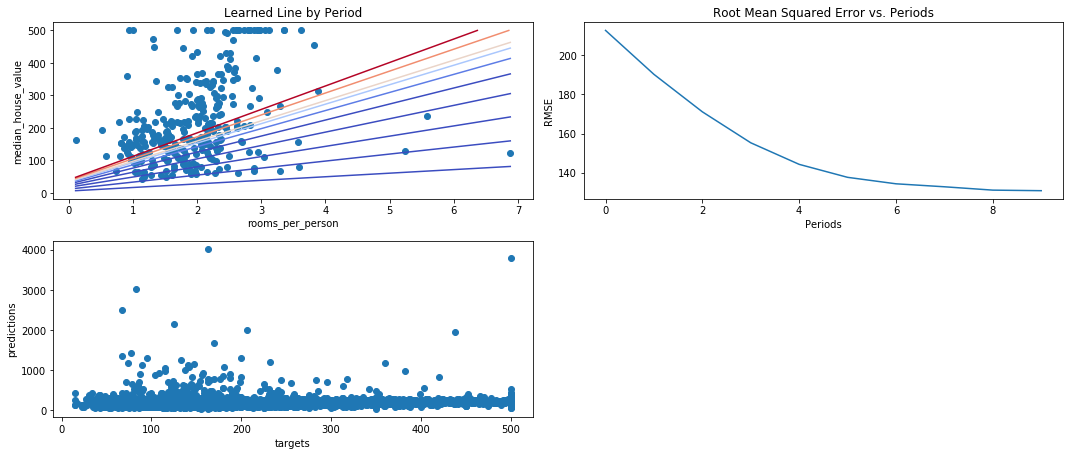

In [39]:
calibration_data = train_model(.05, steps=500, batch_size=5, input_feature='rooms_per_person')

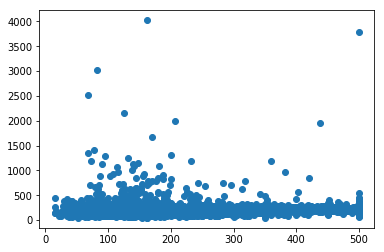

In [40]:
plt.scatter(calibration_data['targets'], calibration_data['predictions'])

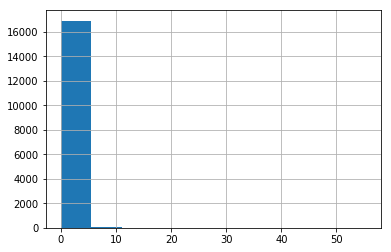

In [46]:
california_housing_dataframe['rooms_per_person'].hist()

In [52]:
california_housing_dataframe[calibration_data['predictions']<500]['rooms_per_person'].head(10)

0    5.529064
2    2.162162
3    2.914563
4    2.330128
5    2.067064
6    1.579033
7    2.165333
8    1.528079
9    1.902160
10   1.536976
Name: rooms_per_person, dtype: float64

Training model...
RMSE (on training data):
  period 00 : 213.08
  period 01 : 189.65
  period 02 : 168.86
  period 03 : 148.82
  period 04 : 139.09
  period 05 : 127.62
  period 06 : 119.75
  period 07 : 117.10
  period 08 : 115.46
  period 09 : 112.95
Model training finished.


,predictions,targets
count,17000.000000,17000.000000
mean,172.134308,207.299591
std,44.544434,115.984344
min,41.511951,14.999000
25%,143.686741,119.400002
50%,172.172844,180.399994
75%,196.396545,265.000000
max,379.983246,500.001007


Final RMSE (on training data): 112.95


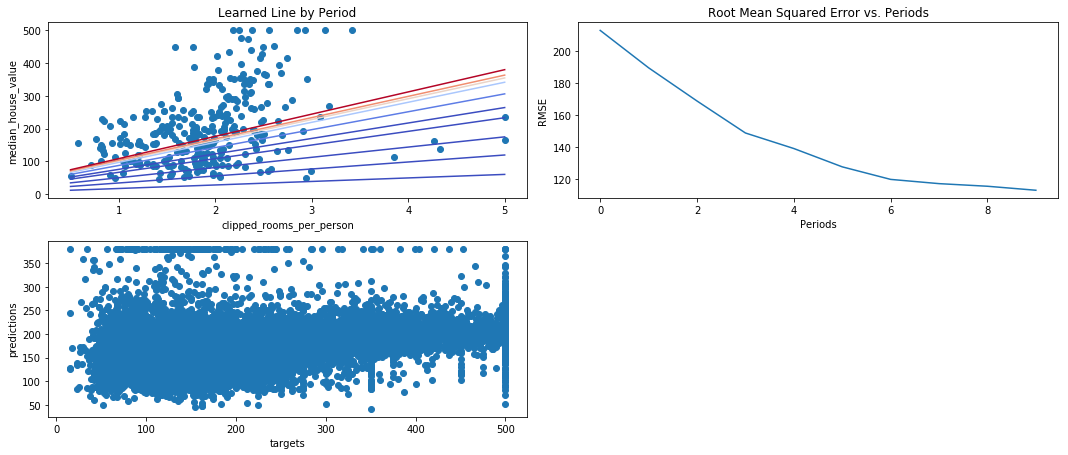

In [57]:
calibration_data = train_model(.05, steps=500, batch_size=5, input_feature='clipped_rooms_per_person')

In [56]:
california_housing_dataframe['clipped_rooms_per_person'] = california_housing_dataframe['rooms_per_person'].apply(lambda x: min(x, 5))